In [1]:
import warnings
warnings.filterwarnings("ignore")
import os.path
import numpy as np
import pandas as pd
from scipy import stats
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, LeaveOneOut

import seaborn as sns
import matplotlib.pyplot as plt
from aggmap import AggMap, AggMapNet, show, loadmap, AggMapNet_DP

In [2]:
#选择哪个GPU进行计算，“2”代表编号为2的GPU
gpu_id = "1"
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

In [3]:
#Self-definition
file = "Carboplatin" #Carboplatin/Cisplatin/Paclitaxel
cancer = "pancancer" # (UCEC)/pancancer # BLCA/CESC/LUAD/pancancer # (BRCA)
clu_channels = 9
cv = 5
ran_seed = 0

#读入数据集
data_T = pd.read_csv("/raid/mobu/0_datasets/{}_log2expression-response+cancer.csv".format(file), header = 0, index_col = 0)
cv_split = pd.read_csv("/raid/mobu/0_datasets/{}_phenotype.csv".format(file), header = 0, index_col = 0)

if cancer == "pancancer":
    data_T = data_T.drop(columns = "cancer")
else:
    data_T = data_T[data_T["cancer"]==cancer].drop(columns = "cancer")

dataX = data_T.drop(columns = ["response"])
dataY = data_T["response"]

In [4]:
if os.path.isfile("/raid/mobu/1_aggmap/{}-all_DR_channels({})_{}-cv_{}.mp".format(file,clu_channels,cv,ran_seed)):
    mp = loadmap("/raid/mobu/1_aggmap/{}-all_DR_channels({})_{}-cv_{}.mp".format(file,clu_channels,cv,ran_seed))
else:
    if os.path.isfile("/raid/mobu/1_aggmap/{}-all_DR_channels({})_{}-cv_{}.mp".format(file,5,cv,ran_seed)):
        mp = loadmap("/raid/mobu/1_aggmap/{}-all_DR_channels({})_{}-cv_{}.mp".format(file,5,cv,ran_seed))
    else:
        mp = AggMap(dataX, metric = "correlation")
    mp.fit(cluster_channels = clu_channels)
    mp.save("/raid/mobu/1_aggmap/{}-all_DR_channels({})_{}-cv_{}.mp".format(file,clu_channels,cv,ran_seed))

In [5]:
#通过AggMap对象将一维向量转变为多维矩阵
dataX_mp = mp.batch_transform(dataX.values)
dataY_binary = tf.keras.utils.to_categorical(dataY.values,2)

100%|##########| 153/153 [00:44<00:00,  3.45it/s]


In [6]:
def imshow(x_arr,  ax, mode = 'dark',  color_list = ['#1300ff','#ff0c00','#25ff00', '#d000ff','#e2ff00', '#00fff6', \
                                                     '#ff8800', '#fccde5','#178b66', '#8a0075'], x_max = 255, vmin = -1, vmax = 1):
    
    
    assert x_arr.ndim == 3, 'input must be 3d array!'
    w, h, c = x_arr.shape
    assert len(color_list) >= c, 'length of the color list should equal or larger than channel numbers'
    
    x = x_arr.copy()
    x[x == 0] = 'nan'

    xxx = x_arr.sum(axis=-1)
    xxx[xxx != 0] = 'nan'

    if mode == 'dark':
        cmaps = [sns.dark_palette(color, n_colors =  50, reverse=False) for color in color_list]

    else:
        cmaps = [sns.light_palette(color, n_colors =  50, reverse=False) for color in color_list]
        
    for i in range(c):
        data = x[:,:,i]/x_max
        sns.heatmap(data, cmap = cmaps[i], vmin = vmin, vmax = vmax, \
                    yticklabels=False, xticklabels=False, cbar=False, ax=ax) # linewidths=0.005, linecolor = '0.9'

In [7]:
file = f"{file}+{cancer}"

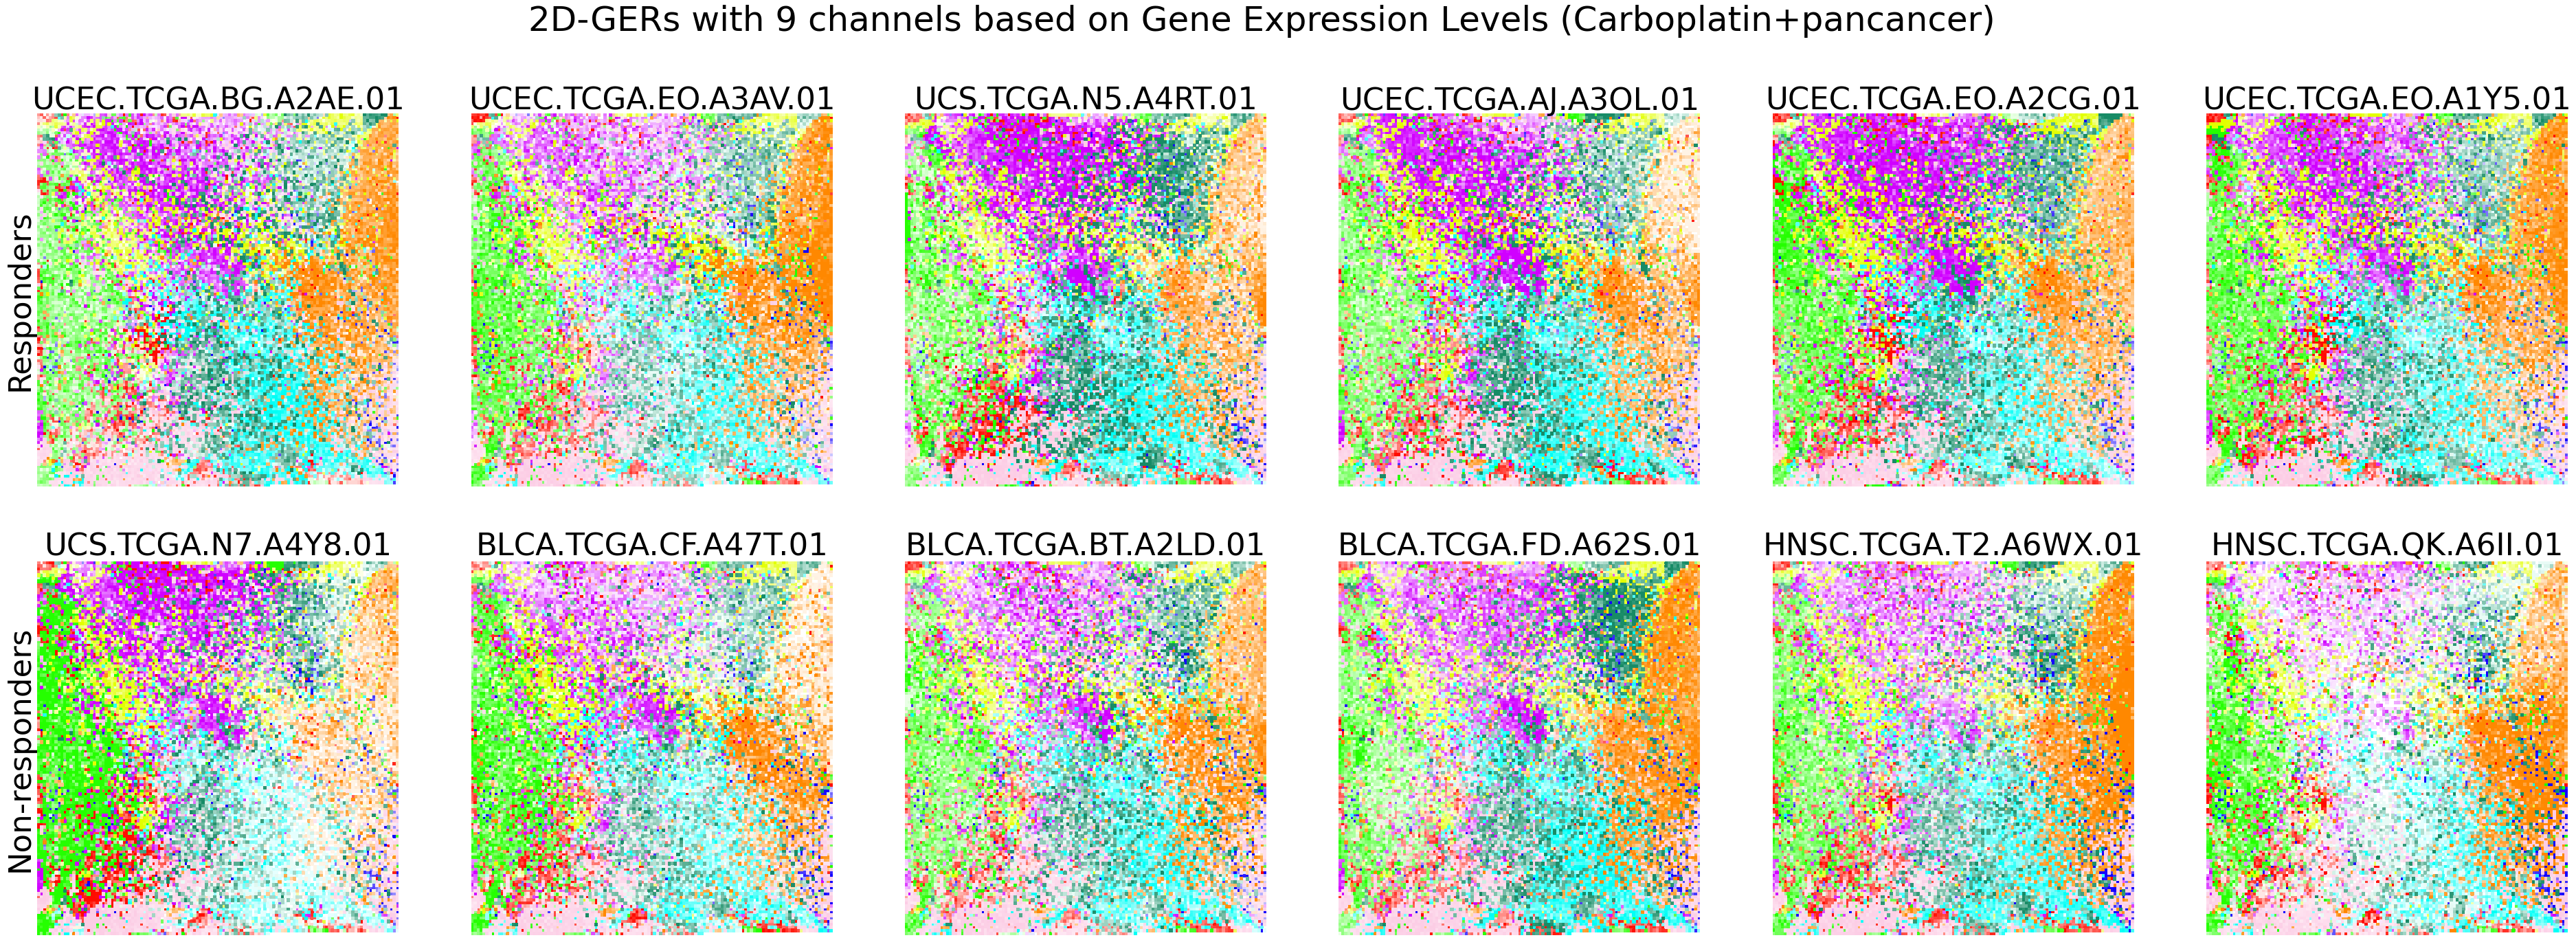

In [8]:
#AggMap output
figure_mp = dataX_mp.copy()
figure_y = dataY.copy()

fv_max = np.percentile(figure_mp.sum(axis = -1), 90)
fv_min = np.percentile(figure_mp.sum(axis = -1), 5)

c_list = ['#1300ff', '#ff0c00', '#25ff00', '#d000ff', '#e2ff00', '#00fff6', '#ff8800', '#fccde5', '#178b66', '#8a0075', \
         '#ff99cc', '#00ccff', '#ff6600', '#339966', '#ccccff', '#008000', "#00ffff", '#00ff00', '#800000', '#cc99ff', \
         '#e1ffff', '#00ced1', '#808000', '#ffa07a', '#f08080', '#ffe4c4', '#ffe4e1', '#ffebcd', '#ffdab9', '#daa520']

ord_mp = np.argsort(figure_y.values)
trvn_list0 = [ord_mp[-1],ord_mp[-2],ord_mp[-3],ord_mp[-4],ord_mp[-5],ord_mp[-6]]
trvn_list1 = [ord_mp[0],ord_mp[1],ord_mp[2],ord_mp[3],ord_mp[4],ord_mp[5]]

fig, axes = plt.subplots(nrows=2, ncols=len(trvn_list0), figsize=(11*len(trvn_list0), 22), sharex = True, sharey = True)

for n,ax in zip(trvn_list0,axes[0]):
    imshow(figure_mp[n], ax, mode="white", color_list = c_list, x_max = 1, vmin = fv_min, vmax = fv_max) #color_list = ["black"]*5
    ax.set_title("{}".format(figure_y.index[n]),fontsize=45)

for n,ax in zip(trvn_list1,axes[1]):
    imshow(figure_mp[n], ax, mode="white", color_list = c_list, x_max = 1, vmin = fv_min, vmax = fv_max) #color_list = ["black"]*5
    ax.set_title("{}".format(figure_y.index[n]),fontsize=45)

fig.suptitle("2D-GERs with {} channels based on Gene Expression Levels ({})".format(clu_channels, file), fontsize=50)
axes[0,0].set_ylabel("Responders",fontsize=45)
axes[1,0].set_ylabel("Non-responders",fontsize=45)

fig.show()
#fig.savefig("/raid/mobu/6_figure/{}_final-channels({})_sample.jpg".format(file, clu_channels))

In [9]:
mp.fmap_shape

(123, 123)